#                 DATA2001 ASSIGNMENT: SYDNEY LIVEABILITY ANALYSIS

# GROUP: F16B-LAB12-2                  SID: 490306336

### 1) LOADING ALL THE LIBRARIES, SETTING UP THE CONNECTION WITH DATABASE AND WRITING A HELPER FUNCTION THAT ENABLES USERS TO VEIW RESULTS OF THE QUERIES WITH query()

In [24]:
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

#Setting up helper function that enables us to view the results of our query
def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result
db, conn = pgconnect(credentials)

Connected successfully.


## SETTING THE SCHEMA 

In [ ]:
conn.execute("set search_path to public")

### CLEANING AND LOADING THE FIRST DATASET FOR ANALYSIS -- Neighbourhood.csv

In [25]:
#Reading the neighbourhood dataset where thousands is used to convert everything to correct data type required (some lines have population and no_of_dwellings as string after line 313)
neighbourhood = pd.read_csv('Neighbourhoods.csv', thousands=',')

#Dropping the first column as it does not provide any useful information
neighbourhood = neighbourhood.drop(['Unnamed: 0'], axis = 1)

#Grouping the ages from 0 to 19 together as a whole
neighbourhood['group0_19'] = neighbourhood['0-4'] + neighbourhood['5-9'] + neighbourhood['10-14'] + neighbourhood['15-19']

#After grouping the ages removing the 4 columns from 0-4, 5-9, 10-14, 15-19
neighbourhood = neighbourhood.drop(['0-4','5-9','10-14','15-19'], axis = 1)

#Renaming column group0_19
neighbourhood = neighbourhood.rename(columns={'group0_19': 'age_group_0_to_19'})

#Drop rows with null values
neighbourhood = neighbourhood.dropna()

### CREATING A TABLE FOR Neighbourhoods DATASET

In [26]:
#Creating the table for neighbourhood after cleaning it
conn.execute("""
DROP TABLE IF EXISTS neighbourhood;
CREATE TABLE neighbourhood (
    area_id INTEGER PRIMARY KEY, 
    area_name VARCHAR(80),
    land_area NUMERIC,
    population INTEGER,
    number_of_dwellings INTEGER,
    number_of_businesses INTEGER,
    median_annual_household_income INTEGER,
    avg_monthly_rent INTEGER,
    Age_Group_0_to_19 INTEGER
);"""
)
#Using the .to_sql() function which will appends rows only if the table exists by ignoring the index and will fill the neighbourhood table
neighbourhood.to_sql("neighbourhood", con=conn, if_exists='append', index=False)

#Helper function used to confirm if data loaded successfully or not
query(conn, "select * from neighbourhood")


,area_id,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,age_group_0_to_19
0,102011028,Avoca Beach - Copacabana,643.8000,7590,2325,738,46996,1906,2214
1,102011029,Box Head - MacMasters Beach,3208.6000,10986,3847,907,42621,1682,2635
2,102011030,Calga - Kulnura,76795.1000,4841,1575,1102,42105,1182,1098
3,102011031,Erina - Green Point,3379.3000,14237,4450,1666,43481,1595,3227
4,102011032,Gosford - Springfield,1691.2000,19385,6373,2126,45972,1382,4219
...,...,...,...,...,...,...,...,...,...
304,106011109,Cessnock Region,1570.4341,7931,3281,673,73164,1080,2126
305,106011113,Singleton Region,4067.2349,4919,2055,698,87984,1000,1380
306,111021218,Morisset - Cooranbong,330.5208,14959,6298,1154,58084,1260,3458
307,114021285,Hill Top - Colo Vale,174.3752,6025,2249,400,81120,1512,1864


### CLEANING AND LOADING THE SECOND DATASET FOR ANALYSIS -- BusinessStats.csv

In [27]:
#Reading the dataset
business = pd.read_csv('BusinessStats.csv')

#Drop rows with null values
business= business.dropna()

#To macth area_id and area_name of businessstats table with neighbourhood we use isin() function of pandas dataframe and it should also have all the columns for retail trade that are required to calculate z-score
business = business[business['area_id'].isin(neighbourhood['area_id'])]

#Changing column names
business = business.rename(columns={'number_of_businesses':'no_of_busi', 'accommodation_and_food_services':'acc_food_ser','agriculture_forestry_and_fishing':'agri_fishing', 'health_care_and_social_assistance':'healthcare','public_administration_and_safety':'admin_safety','transport_postal_and_warehousing':'transport'})


### CREATING A TABLE FOR BusinessStats DATASET 

In [28]:
#Creating the table for business after cleaning it
conn.execute("""
DROP TABLE IF EXISTS business;
CREATE TABLE business (
    area_id INTEGER PRIMARY KEY,
    area_name VARCHAR(100),
    no_of_busi INTEGER,
    acc_food_ser INTEGER,
    retail_trade INTEGER,
    agri_fishing INTEGER,
    healthcare INTEGER,
    admin_safety INTEGER,
    transport INTEGER
);"""
)
#Using the .to_sql() function which will appends rows only if the table exists by ignoring the index and will fill the neighbourhood table
business.to_sql("business", con=conn, if_exists='append', index=False)

#Helper function used to confirm if data loaded successfully or not
query(conn, "select * from business")



,area_id,area_name,no_of_busi,acc_food_ser,retail_trade,agri_fishing,healthcare,admin_safety,transport
0,101051540,Goulburn Region,1891,38,52,1041,33,3,81
1,102011028,Avoca Beach - Copacabana,724,33,35,4,60,0,19
2,102011029,Box Head - MacMasters Beach,934,23,45,13,43,3,28
3,102011030,Calga - Kulnura,1134,14,43,231,12,0,55
4,102011031,Erina - Green Point,1712,68,145,19,179,12,43
...,...,...,...,...,...,...,...,...,...
304,128021536,Oyster Bay - Como - Jannali,1655,52,84,15,92,11,120
305,128021538,Sutherland - Kirrawee,2136,73,113,6,127,17,122
306,128021607,Engadine,1106,37,69,3,82,9,51
307,128021608,Loftus - Yarrawarrah,452,9,20,3,25,5,31


### CLEANING AND LOADING THE THIRD DATASET -- SA2 Shapefile

In [33]:
#Loading the spatial dataset - sa2
sa2 = gpd.read_file("SA2_2016_AUST/SA2_2016_AUST.shp")

# #Setting the srid to WGS84
srid = 4326

# #Helper function that converts all the geometry column to MultiPolygon followed by the Well-Known-Text Conversion
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

# #removing None values from dataset for geometry with for loop
for index, row in sa2.iterrows():
    if row['geometry'] == None:
        sa2.drop(index, inplace=True)

#Creating a copy of the original data to later use it for data visaulisation 
sa2og = sa2.copy()

#Applying the function to the dataset
sa2['geom'] = sa2['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
sa2 = sa2.drop(columns="geometry")

#We keep SA2_MAIN16, SA2_NAME16 and GEOMETRY and drop all the other columns as we are only concerned with SA2 and the other information provided is not required
sa2 = sa2.drop(['SA2_5DIG16','SA3_CODE16','SA3_NAME16','SA4_CODE16','SA4_NAME16','GCC_CODE16','GCC_NAME16','STE_CODE16','STE_NAME16'], axis = 1)

#Changing column names
sa2 = sa2.rename(columns={'SA2_MAIN16': 'area_id','SA2_NAME16': 'area_name','AREASQKM16': 'sqkm16_area'})

### CREATING A TABLE FOR THE SA2 DATASET

In [156]:
#Creating the table for SA2 after cleaning it
conn.execute("""
DROP TABLE IF EXISTS sa2;
CREATE TABLE sa2 (
    area_id INTEGER PRIMARY KEY,
    area_name VARCHAR(100),
    sqkm16_area NUMERIC,
    geom GEOMETRY(MULTIPOLYGON, 4326)
);"""
)
#Using the .to_sql() function which will appends rows only if the table exists by ignoring the index and will fill the neighbourhood table
sa2.to_sql('sa2', con=conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', 4326)})

#Helper function used to confirm if data loaded successfully or not
query(conn, "select * from sa2")

Error encountered: 
'dict' object does not support indexing


""


### CLEANING AND LOADING THE FOURTH DATASET -- Break and Enter Shapefile

In [31]:
#Loading the break_and_enter dataset
be = gpd.read_file("break_and_enter/BreakEnterDwelling_JanToDec2021.shp")

#Creating a copy of the original data to later use it for data visaulisation 
beog = be.copy()

#Applying the helper function WKT to convert to MultiPolygon
be['geom'] = be['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=4326))
be = be.drop(columns="geometry")

#Dropping extra columns that are not required
be = be.drop(['Contour','ORIG_FID'], axis = 1)

#Renaming columns
be = be.rename(columns={'OBJECTID':'area_id', 'Density':'den', 'Shape_Leng':'s_leng', 'Shape_Area':'s_area'})

### CREATING A TABLE FOR THE Break and Enter Shapefile

In [35]:
#Creating the table for be after cleaning it
conn.execute("""
DROP TABLE IF EXISTS be;
CREATE TABLE be (
    area_id INTEGER PRIMARY KEY,
    den VARCHAR(100),
    s_leng NUMERIC,
    s_area NUMERIC,
    geom GEOMETRY(MULTIPOLYGON, 4326)
);"""
)
#Using the .to_sql() function which will appends rows only if the table exists by ignoring the index and will fill the break and enter table
be.to_sql('be', con=conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', 4326)})

#Helper function used to confirm if data loaded successfully or not
query(conn, "select * from be")

,area_id,den,s_leng,s_area,geom
0,1,Low Density,0.012138,0.000006,0106000020E61000000100000001030000000100000015...
1,2,Low Density,0.019106,0.000015,0106000020E6100000010000000103000000010000001D...
2,3,Low Density,0.006068,0.000002,0106000020E61000000100000001030000000100000007...
3,4,Low Density,0.011006,0.000006,0106000020E6100000010000000103000000010000000E...
4,5,Low Density,0.008073,0.000003,0106000020E6100000010000000103000000010000000F...
...,...,...,...,...,...
2589,2590,High Density,0.015358,0.000011,0106000020E61000000100000001030000000100000016...
2590,2591,High Density,0.028327,0.000029,0106000020E61000000100000001030000000100000028...
2591,2592,High Density,0.006654,0.000002,0106000020E61000000100000001030000000100000009...
2592,2593,High Density,0.047098,0.000044,0106000020E6100000010000000103000000010000004D...


### CLEANING AND LOADING THE FIFTH DATASET -- School Catchments Shapefile

### CLEANING THE FIRST SHAPEFILE FOR SCHOOL CATCHMENTS -- Primary

In [36]:
#As school_catchments has three shapefile, i.e., primary, secondary and future all of them are cleaned and loaded separately before combining them together

#Loading the primary shapefile
catchments_p = gpd.read_file('school_catchments/catchments_primary.shp')

# Removing extra columns for the years in school and keeping the rest for analysis
catchments_p = catchments_p.drop(['KINDERGART','YEAR1','YEAR2','YEAR3','YEAR4','YEAR4','YEAR5','YEAR6','YEAR7','YEAR8','YEAR9','YEAR10','YEAR11','YEAR12','PRIORITY'], axis = 1)



### CLEANING THE SECOND SHAPEFILE FOR SCHOOL CATCHMENTS -- Secondary

In [37]:
#Loading the secondary shapefile
catchments_s = gpd.read_file('school_catchments/catchments_secondary.shp')

# Removing extra columns for the years in school and keeping the rest for analysis
catchments_s = catchments_s.drop(['KINDERGART','YEAR1','YEAR2','YEAR3','YEAR4','YEAR4','YEAR5','YEAR6','YEAR7','YEAR8','YEAR9','YEAR10','YEAR11','YEAR12','PRIORITY'], axis = 1)


### CLEANING THE THIRD SHAPEFILE FOR SCHOOL CATCHMENTS -- Future

In [38]:
#Loading the future shapefile
catchments_f = gpd.read_file('school_catchments/catchments_secondary.shp')

# Removing extra columns for the years in school and keeping the rest for analysis
catchments_f = catchments_f.drop(['KINDERGART','YEAR1','YEAR2','YEAR3','YEAR4','YEAR4','YEAR5','YEAR6','YEAR7','YEAR8','YEAR9','YEAR10','YEAR11','YEAR12','PRIORITY'], axis = 1)


### COMBINING ALL THE THREE SHAPEFILES TOGETHER ACROSS ROWS & COLUMNS USING CONCAT() FUNCTION

In [39]:
#Combining all the tree files together using concat()
catchments = pd.concat([catchments_p, catchments_s, catchments_f])

#Creating a copy of the original data to later use it for data visaulisation 
catchmentsog = catchments.copy()

#Applying the helper function WKT to convert to MultiPolygon
catchments['geom'] = catchments['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=4326))
catchments = catchments.drop(columns="geometry")

#Renaming columns
catchments = catchments.rename(columns={'USE_ID':'use_id', 'CATCH_TYPE':'catch_type', 'USE_DESC':'use_desc', 'ADD_DATE':'add_date'})


### CREATING A TABLE FOR THE School Catchments DATASET

In [40]:
#Creating the table for catchments after cleaning it
conn.execute("""
DROP TABLE IF EXISTS catchments;
CREATE TABLE catchments (
    use_id INTEGER,
    catch_type VARCHAR(100),
    use_desc VARCHAR(100),
    add_date INTEGER,
    geom GEOMETRY(MULTIPOLYGON, 4326)
);"""
)
#Using the .to_sql() function which will appends rows only if the table exists by ignoring the index and will fill the break and enter table
catchments.to_sql('catchments', con=conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', 4326)})

#Helper function used to confirm if data loaded successfully or not
query(conn, "select * from catchments")

,use_id,catch_type,use_desc,add_date,geom
0,2838,PRIMARY,Parklea PS,20181210.0,0106000020E61000000100000001030000000100000078...
1,3943,PRIMARY,Gordon WPS,20211219.0,0106000020E6100000010000000103000000010000006F...
2,2404,PRIMARY,Lindfield EPS,20211219.0,0106000020E610000001000000010300000001000000BE...
3,1498,PRIMARY,Brisbania PS,20211115.0,0106000020E6100000010000000103000000010000001F...
4,4393,PRIMARY,Carlingford WPS,20220223.0,0106000020E61000000100000001030000000100000065...
...,...,...,...,...,...
2531,8213,HIGH_BOYS,Birrong BHS,20211221.0,0106000020E61000000100000001030000000100000040...
2532,8857,HIGH_GIRLS,GRC Penshurst Girls,20220110.0,0106000020E610000001000000010300000001000000A1...
2533,3235,CENTRAL_HIGH,Tooleybuc CS,20200512.0,0106000020E6100000010000000103000000010000003E...
2534,1115,CENTRAL_HIGH,Balranald CS,20200512.0,0106000020E6100000010000000103000000010000005B...


### CLEANING AND LOADING EXTRA DATASET 1 -- GREENHOUSE GAS EMISSIONS BY SUBURB (Spatial GeoJSON)

In [141]:
greenhouse = gpd.read_file('Greenhouse.geojson')

# #removing None values from dataset for geometry with for loop
for index, row in greenhouse.iterrows():
    if row['geometry'] == None:
        greenhouse.drop(index, inplace=True)

#Creating a copy of the original data to later use it for data visaulisation 
greenhouseog = greenhouse.copy()

#Applying the function WKT to convert to MultiPolygon to the dataset 
greenhouse['geom'] = greenhouse['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=4326))
greenhouse = greenhouse.drop(columns="geometry")

#Drop extra columns
greenhouse = greenhouse.drop(['Data_Category','F2005_06','F2006_07','F2007_08','F2008_09','F2009_10','F2010_11','F2011_12','F2012_13','F2013_14','F2014_15','F2015_16','F2016_17','F2017_18','F2018_19'], axis = 1)

#Changing column names
greenhouse = greenhouse.rename(columns={'OBJECTID1':'o_id', 'Area_suburb':'area_name','Shape__Length':'s_leng', 'Shape__Area':'s_area'})


### CREATING A TABLE FOR THE FIRST EXTRA DATASET

In [152]:
#Creating the table for greenhouse after cleaning it
conn.execute("""
DROP TABLE IF EXISTS greenhouse;
CREATE TABLE greenhouse (
    o_id INTEGER PRIMARY KEY,
    area_name VARCHAR(100),
    s_leng NUMERIC,
    s_area NUMERIC,
    geom GEOMETRY(MULTIPOLYGON, 4326)
);"""
)
#Using the .to_sql() function which will appends rows only if the table exists by ignoring the index and will fill the greenhouse table
greenhouse.to_sql('greenhouse', con=conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', 4326)})

#Helper function used to confirm if data loaded successfully or not
query(conn, "select * from greenhouse")

,o_id,area_name,s_leng,s_area,geom
0,1,Newtown + St Peters,8815.394724,1.427271e+06,0106000020E61000000200000001030000000100000052...
1,19,Chippendale,3814.859293,6.694250e+05,0106000020E61000000100000001030000000100000056...
2,20,Chippendale,3814.859293,6.694250e+05,0106000020E61000000100000001030000000100000056...
3,2,Newtown + St Peters,8815.394724,1.427271e+06,0106000020E61000000200000001030000000100000052...
4,21,Chippendale,3814.859293,6.694250e+05,0106000020E61000000100000001030000000100000056...
...,...,...,...,...,...
169,172,The Rocks,3549.527779,3.091627e+05,0106000020E61000000100000001030000000100000007...
170,173,The Rocks,3549.527779,3.091627e+05,0106000020E61000000100000001030000000100000007...
171,174,The Rocks,3549.527779,3.091627e+05,0106000020E61000000100000001030000000100000007...
172,156,Potts Point,6898.167594,8.709856e+05,0106000020E6100000010000000103000000010000001B...


### CLEANING AND LOADING EXTRA DATASET 2 -- LIBRARY LOCATIONS (Spatial GeoJSON)

In [142]:
library = gpd.read_file('Library.geojson')

#Drop extra columns
library = library.drop(['Streetnumber','Streetextra','Postcode','Street','Name'], axis = 1)

#Changing column names
library = library.rename(columns={'OBJECTID':'o_id','Suburb':'area_name', 'geometry':'geom'})

#Creating a copy of the original data to later use it for data visaulisation 
libraryog = library.copy()

#Applying the function WKT to the dataset for POINT
library['geom'] = library['geom'].apply(lambda x: WKTElement(x.wkt, srid=4326))


### CREATING A TABLE FOR THE SECOND EXTRA DATASET

In [173]:
#Creating the table for library after cleaning it
conn.execute("""
DROP TABLE IF EXISTS library;
CREATE TABLE library (
    o_id INTEGER,
    area_name VARCHAR(100),
    geom GEOMETRY(POINT, 4326)
);"""
)
#Using the .to_sql() function which will appends rows only if the table exists by ignoring the index and will fill the greenhouse table
library.to_sql('library', con=conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', 4326)})

#Helper function used to confirm if data loaded successfully or not
query(conn, "select * from library")

,area_id


## CREATING INDEXES

In [ ]:
#To make processing of spatial joins faster and quicker, spatial indexes are created

#Index for catchments table based on the column geom
conn.execute("""
DROP INDEX IF EXISTS catchments_geom_idx;
CREATE INDEX catchments_geom_idx ON catchments USING GIST (geom);
""")

#Index for break and enter table based on the column geom
conn.execute("""
DROP INDEX IF EXISTS break_and_enter_geom_idx;
CREATE INDEX break_and_enter_geom_idx ON be USING GIST (geom);
""")

#Index for greenhouse gas (extra dataset GeoJSON format) dataset based on the column geom
conn.execute("""
DROP INDEX IF EXISTS greenhouse_geom_idx;
CREATE INDEX greenhouse_geom_idx ON greenhouse USING GIST (geom);
""")

## VISUALISING ALL THE SHAPEFILE AND THEIR GEOM WITH HELP OF .plot() function BEFORE CALCULATING THE Z-SCORE

In [ ]:
#Plot for sa2 
sa2og.plot(figsize=(10, 10),color = "red");

In [ ]:
#Plot for catchments
catchmentsog.plot(figsize=(10,10),color = "red");

In [ ]:
#Plot for greenhouse
greenhouseog.plot(figsize=(10, 10), color = "red");

In [ ]:
#Plot for break and enter
#Black colour is chosen instead of blue for better visibility
beog.plot(figsize=(10, 10), color="red");

## CALCULATING Z-SCORE FOR THE DATASETS PROVIDED

### CALCULATING Z-SCORE FOR SCHOOL 

In [169]:
#Creating table that will contain Z-score 
conn.execute("""
DROP TABLE IF EXISTS school_score;
CREATE TABLE school_score (
    area_id INTEGER,
    count_s FLOAT
);"""
)

#setting a table that we got from spatial join
school_up = query(conn, 'SELECT sa2.area_id, count(sa2.area_id) AS "count_s" FROM sa2 JOIN Catchments ON ST_INTERSECTS(sa2.geom,catchments.geom) GROUP BY sa2.area_id')

#using .to_sql() function to copy the data into the table
school_up.to_sql('school_score', con=conn, if_exists='append', index=False) 


#Adding a column for population
query(conn,'ALTER TABLE school_score ADD population FLOAT')

#updating population column
query(conn,'UPDATE school_score SET population = neighbourhood.Age_Group_0_to_19 FROM neighbourhood WHERE neighbourhood.area_id = school_score.area_id')

#Adding a column for school population ratio
query(conn,'ALTER TABLE school_score ADD school_pop_r FLOAT ')

#multiplying count_s by 1000 for food population ratio
query(conn,'UPDATE school_score SET school_pop_r = (count_s*1000)')

#dividing above ratio by total population
query(conn,'UPDATE school_score SET school_pop_r = school_pop_r / population')

#Adding a column for z-score
query(conn,'ALTER TABLE school_score ADD z_score FLOAT')

# updating z-score with food_pop_ratio
query(conn,'UPDATE school_score SET z_score = school_pop_r')

# updating z-score with subtracting mean with help of sum/count from z-score 
query(conn,'UPDATE school_score SET z_score = z_score - (SELECT SUM(school_pop_r)/COUNT(school_pop_r) FROM school_score)')

#Final z-score after diving the above one with SD
query(conn,'UPDATE school_score SET z_score = z_score / (SELECT STDDEV(school_pop_r) FROM school_score)')

query(conn, "select * from school_score")


Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.


,area_id,count_s,population,school_pop_r,z_score
0,124021456,35.0,NaN,NaN,NaN
1,101021007,20.0,NaN,NaN,NaN
2,101021008,9.0,NaN,NaN,NaN
3,101021009,8.0,NaN,NaN,NaN
4,101021010,6.0,NaN,NaN,NaN
...,...,...,...,...,...
616,128021536,18.0,6210.0,2.898551,-0.105033
617,128021538,19.0,4894.0,3.882305,-0.086279
618,128021607,15.0,5176.0,2.897991,-0.105043
619,128021608,8.0,2054.0,3.894839,-0.086040


### CALCULATING Z-SCORE FOR ACCOM

In [164]:
#Creating table that will contain Z-score 
conn.execute("""
DROP TABLE IF EXISTS accom_score;
CREATE TABLE accom_score (
    area_id INTEGER,
    acc_food_ser FLOAT,
    population FLOAT
);"""
)

#setting a table that we got from joining neighbourhood and business
accom_up = query(conn, 'SELECT n.area_id, population, acc_food_ser FROM neighbourhood n, business b WHERE n.area_id = b.area_id')

#using .to_sql() function to copy the data into the table
accom_up.to_sql('accom_score', con=conn, if_exists='append', index=False) 

#Adding a column for food population ratio
query(conn,'ALTER TABLE accom_score ADD food_pop_r FLOAT ')

#Adding a column for z-score
query(conn,'ALTER TABLE accom_score ADD z_score FLOAT ')

#multiplying acc_food_ser by 1000 for food population ratio
query(conn,'UPDATE accom_score SET food_pop_r = (acc_food_ser*1000)')

#dividing above ratio by total population
query(conn,'UPDATE accom_score SET food_pop_r = food_pop_r / population')

# updating z-score with food_pop_ratio
query(conn,'UPDATE accom_score SET z_score = food_pop_r')

# updating z-score with subtracting mean with help of sum/count from z-score 
query(conn,'UPDATE accom_score SET z_score = z_score - (SELECT SUM(food_pop_r)/COUNT(food_pop_r) FROM accom_score)')

#Final z-score after diving the above one with SD
query(conn,'UPDATE accom_score SET z_score = z_score / (SELECT STDDEV(food_pop_r) FROM accom_score)')


query(conn, "select * from accom_score")

Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.


,area_id,acc_food_ser,population,food_pop_r,z_score
0,102011028,33.0,7590.0,4.347826,0.140544
1,102011029,23.0,10986.0,2.093574,-0.472598
2,102011030,14.0,4841.0,2.891964,-0.255441
3,102011031,68.0,14237.0,4.776287,0.257083
4,102011032,94.0,19385.0,4.849110,0.276890
...,...,...,...,...,...
304,106011109,21.0,7931.0,2.647838,-0.321842
305,106011113,13.0,4919.0,2.642814,-0.323208
306,111021218,31.0,14959.0,2.072331,-0.478376
307,114021285,12.0,6025.0,1.991701,-0.500306


### CALCULATING Z-SCORE FOR RETAIL

In [158]:
#Creating table that will contain Z-score 
conn.execute("""
DROP TABLE IF EXISTS retail_score;
CREATE TABLE retail_score (
    area_id INTEGER,
    retail_trade FLOAT,
    population FLOAT
);"""
)

#setting a table that we got from joining neighbourhood and business
retail_up = query(conn, 'SELECT n.area_id, population, retail_trade FROM neighbourhood n,business b WHERE n.area_id = b.area_id')

#using .to_sql() function to copy the data into the table
retail_up.to_sql('retail_score', con=conn, if_exists='append', index=False) 

#Adding a column for retail population ratio
query(conn,'ALTER TABLE retail_score ADD retail_pop_r FLOAT ')

#Adding a column for z-score
query(conn,'ALTER TABLE retail_score ADD z_score FLOAT ')

#multiplying retail_trade by 1000 for retail population ratio
query(conn,'UPDATE retail_score SET retail_pop_r = (retail_trade*1000)')

#dividing above ratio by total population
query(conn,'UPDATE retail_score SET retail_pop_r = retail_pop_r / population')

# updating z-score with food_pop_ratio
query(conn,'UPDATE retail_score SET z_score = retail_pop_r')

# updating z-score with subtracting mean with help of sum/count from z-score 
query(conn,'UPDATE retail_score SET z_score = z_score - (SELECT SUM(retail_pop_r)/COUNT(retail_pop_r) FROM retail_score)')

#Final z-score after diving the above one with SD
query(conn,'UPDATE retail_score SET z_score = z_score / (SELECT STDDEV(retail_pop_r) FROM retail_score)')

query(conn, "select * from retail_score")

Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.


,area_id,retail_trade,population,retail_pop_r,z_score
0,102011028,35.0,7590.0,4.611331,-0.263253
1,102011029,45.0,10986.0,4.096122,-0.361426
2,102011030,43.0,4841.0,8.882462,0.550609
3,102011031,145.0,14237.0,10.184730,0.798755
4,102011032,167.0,19385.0,8.614908,0.499627
...,...,...,...,...,...
304,106011109,32.0,7931.0,4.034800,-0.373111
305,106011113,11.0,4919.0,2.236227,-0.715828
306,111021218,73.0,14959.0,4.880005,-0.212057
307,114021285,20.0,6025.0,3.319502,-0.509410


### CALCULATING Z-SCORE FOR CRIME

In [159]:
#Creating table that will contain z-score
conn.execute("""
DROP TABLE IF EXISTS crime_score;
CREATE TABLE crime_score(
area_id INTEGER,
crime_per_sqkm16 FLOAT)
""")

#Adding a column for z-score
query(conn,'ALTER TABLE crime_score ADD z_score FLOAT ')

#setting a table that we got from spatial join and using ST_CONTAINS()
crime_up = query(conn, 'SELECT s.area_id, COUNT(s.area_id)/s.sqkm16_area AS "crime_per_sqkm16" FROM sa2 s JOIN be b ON ST_INTERSECTS (s.geom,b.geom) GROUP BY s.area_id')

#using .to_sql() function to copy the data into the table
crime_up.to_sql('crime_score', con=conn, if_exists='append', index=False) 

# updating z-score with crime_pop_ratio
query(conn,'UPDATE crime_score SET z_score = crime_per_sqkm16')

# updating z-score with subtracting mean with help of sum/count from z-score 
query(conn,'UPDATE crime_score SET z_score = z_score - (SELECT SUM(crime_per_sqkm16)/COUNT(crime_per_sqkm16) FROM crime_score)')

#Final z-score after diving the above one with SD
query(conn,'UPDATE crime_score SET z_score = z_score / (SELECT STDDEV(crime_per_sqkm16) FROM crime_score)')

query(conn,'SELECT * FROM crime_score')


Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.


,area_id,crime_per_sqkm16,z_score
0,101021007,0.000878,-0.893640
1,101021008,0.859291,0.156116
2,101021009,1.679473,1.159118
3,101021010,0.384515,-0.424489
4,101021011,0.000982,-0.893512
...,...,...,...
514,128021538,0.644770,-0.106222
515,128021607,0.335053,-0.484976
516,307011171,0.000032,-0.894674
517,307011173,0.001204,-0.893240


### CALCULATING Z-SCORE FOR HEALTH

In [160]:
#Creating table that will contain Z-score 
conn.execute("""
DROP TABLE IF EXISTS health_score;
CREATE TABLE health_score (
    area_id INTEGER,
    healthcare FLOAT,
    population FLOAT
);"""
)

#setting a table that we got from joining neighbourhood and business
health_up = query(conn, 'SELECT n.area_id, population, healthcare FROM neighbourhood n, business b WHERE n.area_id = b.area_id')

#using .to_sql() function to copy the data into the table
health_up.to_sql('health_score', con=conn, if_exists='append', index=False) 

#Adding a column for health population ratio
query(conn,'ALTER TABLE health_score ADD health_pop_r FLOAT')

#Adding a column for z-score
query(conn,'ALTER TABLE health_score ADD z_score FLOAT')

#multiplying healthcare by 1000 for healthcare population ratio
query(conn,'UPDATE health_score SET health_pop_r = (healthcare*1000)')

#dividing above ratio by total population
query(conn,'UPDATE health_score SET health_pop_r = health_pop_r / population')

# updating z-score with food_pop_ratio
query(conn,'UPDATE health_score SET z_score = health_pop_r')

# updating z-score with subtracting mean with help of sum/count from z-score 
query(conn,'UPDATE health_score SET z_score = z_score - (SELECT SUM(health_pop_r)/COUNT(health_pop_r) FROM health_score)')

#Final z-score after diving the above one with SD
query(conn,'UPDATE health_score SET z_score = z_score / (SELECT STDDEV(health_pop_r) FROM health_score)')

query(conn, "select * from health_score")

Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.
Error encountered: 
This result object does not return rows. It has been closed automatically.


,area_id,healthcare,population,health_pop_r,z_score
0,102011028,60.0,7590.0,7.905138,0.361358
1,102011029,43.0,10986.0,3.914072,-0.468103
2,102011030,12.0,4841.0,2.478827,-0.766389
3,102011031,179.0,14237.0,12.572873,1.331450
4,102011032,246.0,19385.0,12.690224,1.355839
...,...,...,...,...,...
304,106011109,16.0,7931.0,2.017400,-0.862287
305,106011113,10.0,4919.0,2.032934,-0.859059
306,111021218,68.0,14959.0,4.545758,-0.336820
307,114021285,13.0,6025.0,2.157676,-0.833134


# #LIVEABILITY SCORE:


In [121]:
#Making a table that has the respectives scores and adding all of them together for final liveability score
conn.execute("""
DROP TABLE IF EXISTS analysis;
CREATE TABLE analysis AS
SELECT neighbourhood.area_id AS "area_id",
       neighbourhood.area_name AS "area_name",
       accom_score.z_score AS "z_accomm",
       retail_score.z_score AS "z_retail",
       health_score.z_score AS "z_health",
       school_score.z_score AS "z_school",
       crime_score.z_score AS "z_crime",
       (accom_score.z_score + retail_score.z_score + health_score.z_score + school_score.z_score - crime_score.z_score ) AS "liveability_score"
FROM neighbourhood, accom_score, retail_score, health_score, school_score, crime_score
WHERE neighbourhood.area_id = accom_score.area_id AND accom_score.area_id = retail_score.area_id AND retail_score.area_id = health_score.area_id AND health_score.area_id = school_score.area_id AND school_score.area_id = crime_score.area_id
;"""
)

In [122]:
#Applying the Sigmoid Function
query(conn,'UPDATE analysis SET liveability_score = 1/(1+ (1/exp(liveability_score)))')

Error encountered: 
This result object does not return rows. It has been closed automatically.


""


In [123]:
analysis = query(conn, 'SELECT * FROM analysis')


In [162]:
#Setting up the table that has all the z-scores along with area_id and the final liveability score
conn.execute("""
DROP TABLE IF EXISTS analysis_table;
CREATE TABLE analysis_table(
    area_id INTEGER PRIMARY KEY,
    area_name VARCHAR(100),
    z_accomm FLOAT, 
    z_retail FLOAT, 
    z_health FLOAT,
    z_school FLOAT, 
    z_crime FLOAT,
    liveability_score FLOAT
);
"""
)



In [163]:
analysis.to_sql('analysis_table', con=conn, if_exists='append', index=False) 
query(conn, 'SELECT * FROM analysis_table ORDER BY area_id')

,area_id,area_name,z_accomm,z_retail,z_health,z_school,z_crime,liveability_score
0,101051540,Goulburn Region,-0.226270,-0.359890,-0.740255,0.148185,-0.894307,0.429492
1,102011029,Box Head - MacMasters Beach,-0.472598,-0.361426,-0.468103,-0.080707,-0.742260,0.345117
2,102011031,Erina - Green Point,0.257083,0.798755,1.331450,-0.018508,-0.713775,0.956167
3,102011032,Gosford - Springfield,0.276890,0.499627,1.355839,-0.078956,-0.388557,0.919971
4,102011033,Kariong,-0.335019,-0.617492,-0.836668,-0.104818,-0.747487,0.241127
...,...,...,...,...,...,...,...,...
282,128021534,Illawong - Alfords Point,-0.308696,-0.203010,0.032346,-0.093659,-0.391999,0.454868
283,128021535,Menai - Lucas Heights - Woronora,-0.489408,-0.482020,-0.341071,-0.099911,-0.821496,0.356425
284,128021536,Oyster Bay - Como - Jannali,-0.401588,-0.417154,-0.415763,-0.105033,-0.345421,0.270100
285,128021538,Sutherland - Kirrawee,-0.129558,-0.152413,-0.068588,-0.086279,-0.106222,0.418091


## CORRELATION OF LIVEABILITY SCORE WITH MEDIAN RENT IN NEIGHBOURHOOD

In [135]:
#SELECTING THE COLUMN OF SCORE FROM ANALYSIS TABLE AND RENT FROM NEIGHBOURHOOD TO FIND THE CORRELATION
c_1 = query(conn,'SELECT liveability_score,avg_monthly_rent FROM analysis_table a, neighbourhood n WHERE a.area_id = n.area_id')
#FOR GETTING THE CORRELATION BETWEEN THEM
c_1.corr()

,liveability_score,avg_monthly_rent
liveability_score,1.000000,0.371883
avg_monthly_rent,0.371883,1.000000


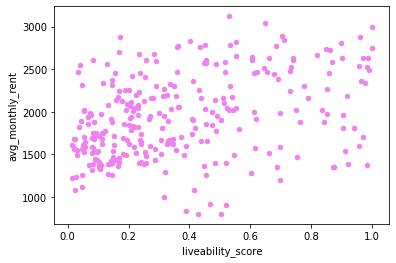

In [136]:
#SCATTER PLOT FOR CORRELATION 1
c_1.plot.scatter(x='liveability_score', y='avg_monthly_rent', c='Violet')

## CORRELATION OF LIVEABILITY SCORE WITH MEDIAN INCOME IN NEIGHBOURHOOD

In [137]:
#SELECTING THE COLUMN OF SCORE FROM ANALYSIS TABLE AND ANNUAL INCOME FROM NEIGHBOURHOOD TO FIND THE CORRELATION
c_2 = query(conn,'SELECT liveability_score,median_annual_household_income FROM analysis_table a, neighbourhood n WHERE a.area_id = n.area_id')
#FOR GETTING THE CORRELATION BETWEEN THEM
c_2.corr()

,liveability_score,median_annual_household_income
liveability_score,1.000000,0.280978
median_annual_household_income,0.280978,1.000000


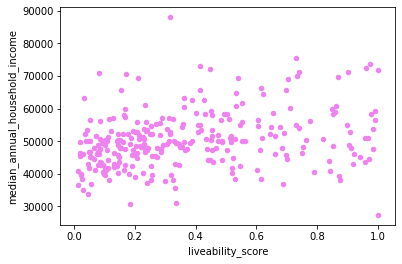

In [138]:
#SCATTER PLOT FOR CORRELATION 2
c_2.plot.scatter(x='liveability_score', y='median_annual_household_income', c='Violet')

## VISUALISATION ON MAP:

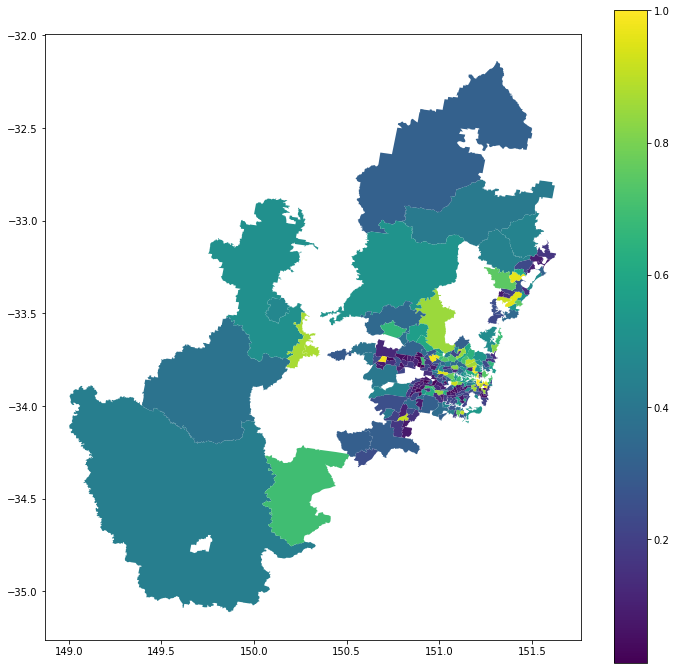

In [177]:
visualise_data.plot(column='liveability_score',legend = True, figsize=(12,12))
